# Thiết lập môi trường

## Tải thư viện cần thiết

In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from craft import CRAFT
from torch.autograd import Variable
import craft_utils
import imgproc
from collections import OrderedDict

import os
import json
import time
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from torch.nn.utils.rnn import pad_sequence
from PIL import Image

## Định nghĩa đường dẫn

In [2]:
ROOT = '..'
DATA_PATH = os.path.join(ROOT, "data")
VIETNAMESE_DATA_PATH = os.path.join(DATA_PATH, "vietnamese")
IIIT5K_DATA_PATH = os.path.join(DATA_PATH, "IIIT5K")
VIETOCR_DATA_PATH = os.path.join(DATA_PATH, "VietOCR")
MODEL_PATH = os.path.join(ROOT, "model")
TEXT_PATH = os.path.join(MODEL_PATH, "text")
CRAFT_MODEL_PATH = os.path.join('.', "craft_mlt_25k.pth")

## Định nghĩa thiết bị

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Mô hình trích xuất vùng text

Link repo: https://github.com/clovaai/CRAFT-pytorch.git

## Các hàm hỗ trợ

In [4]:
def load_craft_model(weight_path, device='cpu'):
    net = CRAFT()
    state_dict = torch.load(weight_path, map_location=device, weights_only=True)
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k.replace('module.', '')
        new_state_dict[name] = v
    net.load_state_dict(new_state_dict)
    net.to(device)
    net.eval()
    return net


def detect_text(net, image, text_threshold=0.7, link_threshold=0.4, low_text=0.4):
    img_resized, target_ratio, _ = imgproc.resize_aspect_ratio(image, 1280, interpolation=cv2.INTER_LINEAR, mag_ratio=1.5)
    ratio_h = ratio_w = 1 / target_ratio
    x = imgproc.normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)
    x = Variable(x.unsqueeze(0)).to(next(net.parameters()).device)

    with torch.no_grad():
        y, _ = net(x)

    score_text = y[0, :, :, 0].cpu().data.numpy()
    score_link = y[0, :, :, 1].cpu().data.numpy()
    boxes, polys = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text)

    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
    polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)

    for i in range(len(polys)):
        if polys[i] is None:
            polys[i] = boxes[i]
    return boxes, polys

def four_point_crop(img, box, out_size=(128, 32)):
    rect = np.array(box).astype(np.float32)
    dst = np.array([[0, 0], [out_size[0], 0], [out_size[0], out_size[1]], [0, out_size[1]]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img, M, out_size)
    return warped

def draw_polygons(image, polys):
    img = image.copy()
    for poly in polys:
        poly = np.array(poly).astype(np.int32).reshape((-1,1,2))
        cv2.polylines(img, [poly], True, (0,255,0), 2)
    return img


def demo_craft_detect(weight_path, img_path, device='cpu'):
    image = cv2.imread(img_path)
    if image is None:
        print("Không tìm thấy ảnh:", img_path)
        return

    net = load_craft_model(weight_path, device)
    boxes, polys = detect_text(net, image)

    print(f"Phát hiện {len(boxes)} vùng text")

    image_poly = draw_polygons(image, polys)

    plt.figure(figsize=(15,10))
    plt.imshow(cv2.cvtColor(image_poly, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("CRAFT detected words")
    plt.show()


## Demo mô hình CRAFT trích xuất vùng chứa text

d:\conda_envs\machine_learning\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\conda_envs\machine_learning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Phát hiện 14 vùng text


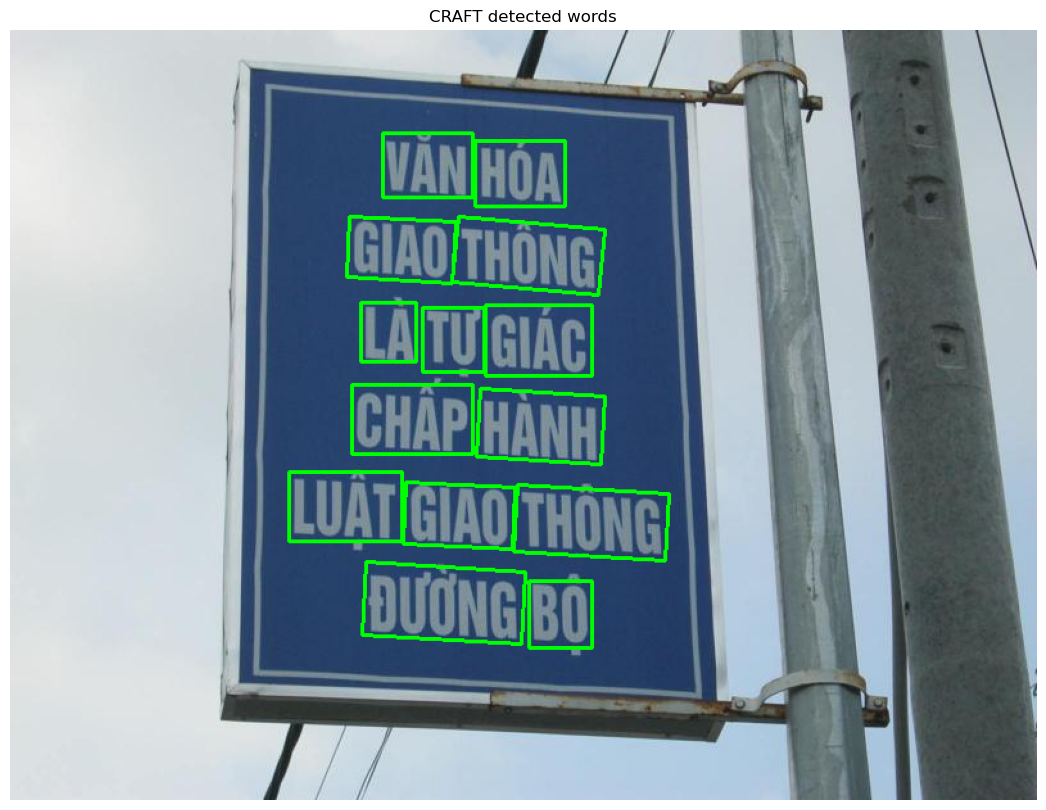

In [46]:
img_path = os.path.join(VIETNAMESE_DATA_PATH, 'train_images', 'im0011.jpg')  # Đường dẫn ảnh

demo_craft_detect(CRAFT_MODEL_PATH, img_path, device=device)

# Định nghĩa lại mô hình OCR

- Định nghĩa lại mô hình OCR để load mô hình đã huấn luyện

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

class CNNFeatureExtractor(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        # Sử dụng ResNet backbone
        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])

        # Thay vì pooling cứng, dùng convolution để giảm chiều
        self.feature_conv = nn.Sequential(
            nn.Conv2d(512, d_model, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(d_model, d_model, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Layer normalization
        self.norm = nn.LayerNorm(d_model)

        # Learnable 2D positional encoding for images
        self.pos_embedding_h = nn.Parameter(torch.randn(32, d_model) * 0.02)  # Max height
        self.pos_embedding_w = nn.Parameter(torch.randn(128, d_model) * 0.02)  # Max width

    def forward(self, x):
        # x: (B, 3, 32, 128)
        features = self.feature_extractor(x)  # (B, 512, H', W')
        features = self.feature_conv(features)  # (B, d_model, H', W')

        B, C, H, W = features.shape

        # Add 2D positional encoding
        pos_h = self.pos_embedding_h[:H].unsqueeze(1).unsqueeze(0).repeat(1, 1, W, 1)  # (1, H, W, d_model)
        pos_w = self.pos_embedding_w[:W].unsqueeze(0).unsqueeze(0).repeat(1, H, 1, 1)  # (1, H, W, d_model)
        pos_encoding = (pos_h + pos_w).permute(0, 3, 1, 2)  # (1, d_model, H, W)

        features = features + pos_encoding

        # Flatten spatial dimensions: (B, d_model, H, W) -> (B, H*W, d_model)
        features = features.view(B, C, H * W).permute(0, 2, 1)
        features = self.norm(features)

        return features

class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, key_padding_mask=None):
        attn_output, attn_weights = self.multihead_attn(
            query=query,
            key=key,
            value=value,
            key_padding_mask=key_padding_mask
        )
        # Residual connection
        output = self.norm(query + self.dropout(attn_output))
        return output, attn_weights


class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=4, dropout=0.1, max_text_len=128):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_text_len)
        self.dropout = nn.Dropout(dropout)

        # Custom decoder layers with cross-attention
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                'self_attn': nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True),
                'cross_attn': MultiHeadCrossAttention(d_model, nhead, dropout=dropout),
                'ffn': nn.Sequential(
                    nn.Linear(d_model, 4 * d_model),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(4 * d_model, d_model)
                ),
                'norm1': nn.LayerNorm(d_model),
                'norm2': nn.LayerNorm(d_model),
                'norm3': nn.LayerNorm(d_model),
            })
            for _ in range(num_layers)
        ])

        self.output_layer = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, memory, tgt_mask=None, tgt_key_padding_mask=None):
        # tgt: (B, L_text), memory: (B, S_img, D)
        B, L = tgt.shape

        # Token embedding + positional encoding
        tgt_emb = self.embedding(tgt) * math.sqrt(self.d_model)
        tgt_emb = self.pos_encoder(tgt_emb)
        tgt_emb = self.dropout(tgt_emb)

        # Store attention weights for visualization
        cross_attention_weights = []

        x = tgt_emb
        for layer in self.layers:
            # Self-attention
            attn_output, _ = layer['self_attn'](
                query=x, key=x, value=x,
                attn_mask=tgt_mask,
                key_padding_mask=tgt_key_padding_mask
            )
            x = layer['norm1'](x + self.dropout(attn_output))

            # Cross-attention with image features
            cross_attn_output, cross_attn_weights = layer['cross_attn'](
                query=x,
                key=memory,
                value=memory
            )
            cross_attention_weights.append(cross_attn_weights)
            x = layer['norm2'](x + cross_attn_output)

            # Feed-forward
            ffn_output = layer['ffn'](x)
            x = layer['norm3'](x + self.dropout(ffn_output))

        logits = self.output_layer(x)

        # Return both logits and attention weights
        return logits, cross_attention_weights


class OCRModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=4, dropout=0.1, max_text_len=128):
        super().__init__()
        self.cnn = CNNFeatureExtractor(d_model)
        self.decoder = TransformerDecoder(
            vocab_size=vocab_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_layers,
            dropout=dropout,
            max_text_len=max_text_len
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, images, input_seqs, tgt_mask=None, tgt_key_padding_mask=None, return_attention=False):
        # Extract features from images
        memory = self.cnn(images)  # (B, S, D)

        # Decode text
        logits, attention_weights = self.decoder(
            tgt=input_seqs,
            memory=memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )

        if return_attention:
            return logits, attention_weights
        return logits

    def generate(self, images, max_length=128, start_token=1, end_token=2, device='cuda', beam_width=5):
        """
        Generate sequences using beam search.
        """
        self.eval()
        with torch.no_grad():
            batch_size = images.size(0)
            assert batch_size == 1, "Beam search hiện tại chỉ hỗ trợ batch size = 1"

            memory = self.cnn(images)  # (1, S, D)

            # Mỗi beam là (sequence, score)
            beams = [(torch.tensor([start_token], device=device), 0.0)]

            for _ in range(max_length - 1):
                new_beams = []
                for seq, score in beams:
                    if seq[-1].item() == end_token:
                        # Nếu đã có end_token thì giữ nguyên beam này
                        new_beams.append((seq, score))
                        continue

                    # Tạo mask cho decoder
                    tgt_mask = self._generate_square_subsequent_mask(len(seq), device)

                    # Dự đoán logits cho seq hiện tại
                    logits, _ = self.decoder(seq.unsqueeze(0), memory, tgt_mask=tgt_mask)
                    logits = logits[:, -1, :]  # (1, vocab_size)
                    log_probs = F.log_softmax(logits, dim=-1).squeeze(0)  # (vocab_size,)

                    # Lấy top beam_width token
                    top_log_probs, top_indices = torch.topk(log_probs, beam_width)

                    # Tạo các beam mới
                    for log_p, idx in zip(top_log_probs, top_indices):
                        new_seq = torch.cat([seq, idx.unsqueeze(0)])
                        new_score = score + log_p.item()
                        new_beams.append((new_seq, new_score))

                # Chọn beam_width beams có điểm cao nhất (log prob lớn nhất)
                beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

                # Nếu tất cả beams đều kết thúc bằng end_token thì dừng
                if all(seq[-1].item() == end_token for seq, _ in beams):
                    break

            # Lấy beam có score cao nhất
            best_seq, best_score = beams[0]
            return best_seq.unsqueeze(0)  # shape (1, seq_len)

    def _generate_square_subsequent_mask(self, size, device):
        """Generate causal mask for decoder"""
        mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
        return mask.to(device)

## Các hàm hỗ trợ

In [7]:
def load_model(model_class, model_path, vocab_size, d_model=512, nhead=8, numlayer=4, max_len=50, device='cpu'):
    """
    Tải mô hình đã lưu từ file .pth

    Args:
        model_class: class của mô hình OCRModel
        model_path: đường dẫn đến file .pth chứa model state_dict
        vocab_size: kích thước từ vựng (vocab_size lúc training)
        d_model: kích thước embedding
        device: 'cuda' hoặc 'cpu'

    Returns:
        model đã load, đã đưa lên device
    """
    model = model_class(vocab_size=vocab_size, d_model=d_model, nhead=nhead, num_layers=numlayer, max_text_len=max_len).to(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model


def decode_tokens(token_list, idx2char):
    chars = []
    for idx in token_list:
        idx = str(idx)
        if idx in idx2char:
            chars.append(idx2char[idx])
        else:
            chars.append("?")  # ký tự thay thế nếu index không có trong idx2char
    return "".join(chars)


# Hàm dự đoán từ ảnh đã cắt
def predict_from_path(model, image, transform, sos_token, eos_token, idx2char, device='cuda', max_len=50, beam_width=5):
    model.eval()
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Gọi hàm generate trong model
    pred_tokens = model.generate(
        image_tensor, max_length=max_len, start_token=sos_token, end_token=eos_token,
        device=device, beam_width=beam_width
    ).squeeze(0).tolist()

    # print(pred_tokens)

    if eos_token in pred_tokens:
        pred_tokens = pred_tokens[:pred_tokens.index(eos_token)]

    pred_str = decode_tokens(pred_tokens, idx2char)
    return pred_str

# Tải dữ liệu và khởi tạo các hyperparameters

In [8]:
# Tải từ điển
vocab_path = os.path.join(TEXT_PATH, "vocab.json")
with open(vocab_path, "r") as f:
    vocab = json.load(f)

print(f"Đã tải từ điển, số lượng từ vựng: {len(vocab['char2idx'])}")

# Các hyperparameters
MAX_LEN = 50
VOCAB_SIZE = len(vocab["char2idx"])
PAD_ID = vocab["char2idx"]["<pad>"]
inference_transform = transforms.Compose([
    transforms.Resize((32, 128)),  # Resize ảnh về kích thước cố định
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization theo ImageNet
])

# Tải mô hình OCR
model = load_model(OCRModel, os.path.join(MODEL_PATH, "ocr_model.pth"), VOCAB_SIZE, d_model=256, max_len=MAX_LEN, device=device)
print("Mô hình OCR đã được tải thành công.")

Đã tải từ điển, số lượng từ vựng: 108
Mô hình OCR đã được tải thành công.


# Dự đoán (Inference)

In [20]:
def inference(model, image_path, transform, weight_path, vocab, device='cuda', max_len=50, beam_width=5):
    """
    Hàm dự đoán văn bản từ ảnh bằng mô hình CRAFT + Transformer OCR
    """
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise FileNotFoundError(f"Không tìm thấy ảnh: {image_path}")
    
    craft_model = load_craft_model(weight_path, device)
    boxes, polys = detect_text(craft_model, image)

    char2idx = vocab["char2idx"]
    idx2char = vocab["idx2char"]
    sos_token = char2idx['<sos>']
    eos_token = char2idx['<eos>']

    print(f"Phát hiện {len(boxes)} vùng chữ trong ảnh.")
    result = []

    # Hiển thị số thứ tự vùng trên ảnh và in kết quả ra console
    for idx, (poly, box) in enumerate(zip(polys, boxes), start=1):
        # Cắt ảnh từ vùng polygon
        # x_min = min([p[0] for p in poly])
        # x_max = max([p[0] for p in poly])
        # y_min = min([p[1] for p in poly])
        # y_max = max([p[1] for p in poly])
        x_min = max(0, int(min([p[0] for p in box])))
        x_max = min(image.shape[1], int(max([p[0] for p in box])))
        y_min = max(0, int(min([p[1] for p in box])))
        y_max = min(image.shape[0], int(max([p[1] for p in box])))

        # Thêm padding
        pad = 5
        x_min = max(0, int(x_min - pad))
        x_max = min(image.shape[1], int(x_max + pad))
        y_min = max(0, int(y_min - pad))
        y_max = min(image.shape[0], int(y_max + pad))

        cropped = image[y_min:y_max, x_min:x_max]
        cropped_pil = Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))

        # Dự đoán văn bản
        pred_text = predict_from_path(
            model, cropped_pil, transform, sos_token, eos_token, idx2char,
            device=device, max_len=max_len, beam_width=beam_width
        )

        # Vẽ bounding box
        pts = np.array(poly).astype(np.int32).reshape((-1, 1, 2))
        cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=2)

        # Hiển thị chỉ số vùng
        x, y = poly[0]
        cv2.putText(image, str(idx), (int(x), int(y)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)

        # In kết quả
        # print(f"[{idx}] {pred_text}")
        result.append({
            "index": idx,
            "text": pred_text,
            "box": box.tolist(),
            "poly": poly
        })

    # Hiển thị ảnh với các vùng đã vẽ và kết quả dự đoán
    plt.figure(figsize=(16, 12))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Vùng chữ được phát hiện & kết quả dự đoán")
    plt.show()

    return result


Phát hiện 4 vùng chữ trong ảnh.


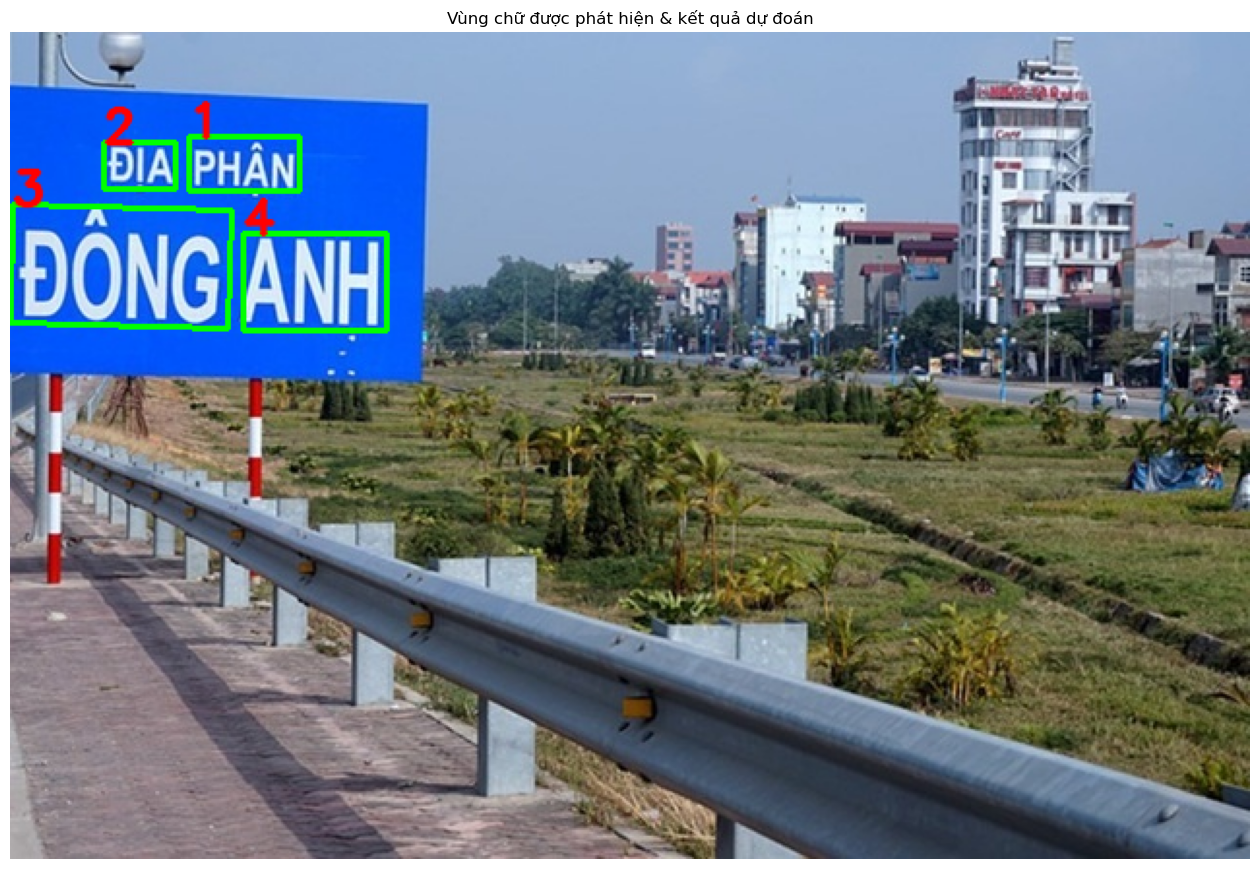


Kết quả dự đoán:
[1]:  <sos>phân
[2]:  <sos>địa
[3]:  <sos>đông
[4]:  <sos>anh


In [45]:
img_path = os.path.join(VIETNAMESE_DATA_PATH, 'unseen_test_images', 'im1832.jpg')

text_detected = inference(model, img_path, inference_transform, CRAFT_MODEL_PATH, vocab=vocab, device=device, max_len=MAX_LEN, beam_width=10)

print("\nKết quả dự đoán:")
for item in text_detected:
    print(f"[{item['index']}]:  {item['text']}")

Phát hiện 40 vùng chữ trong ảnh.


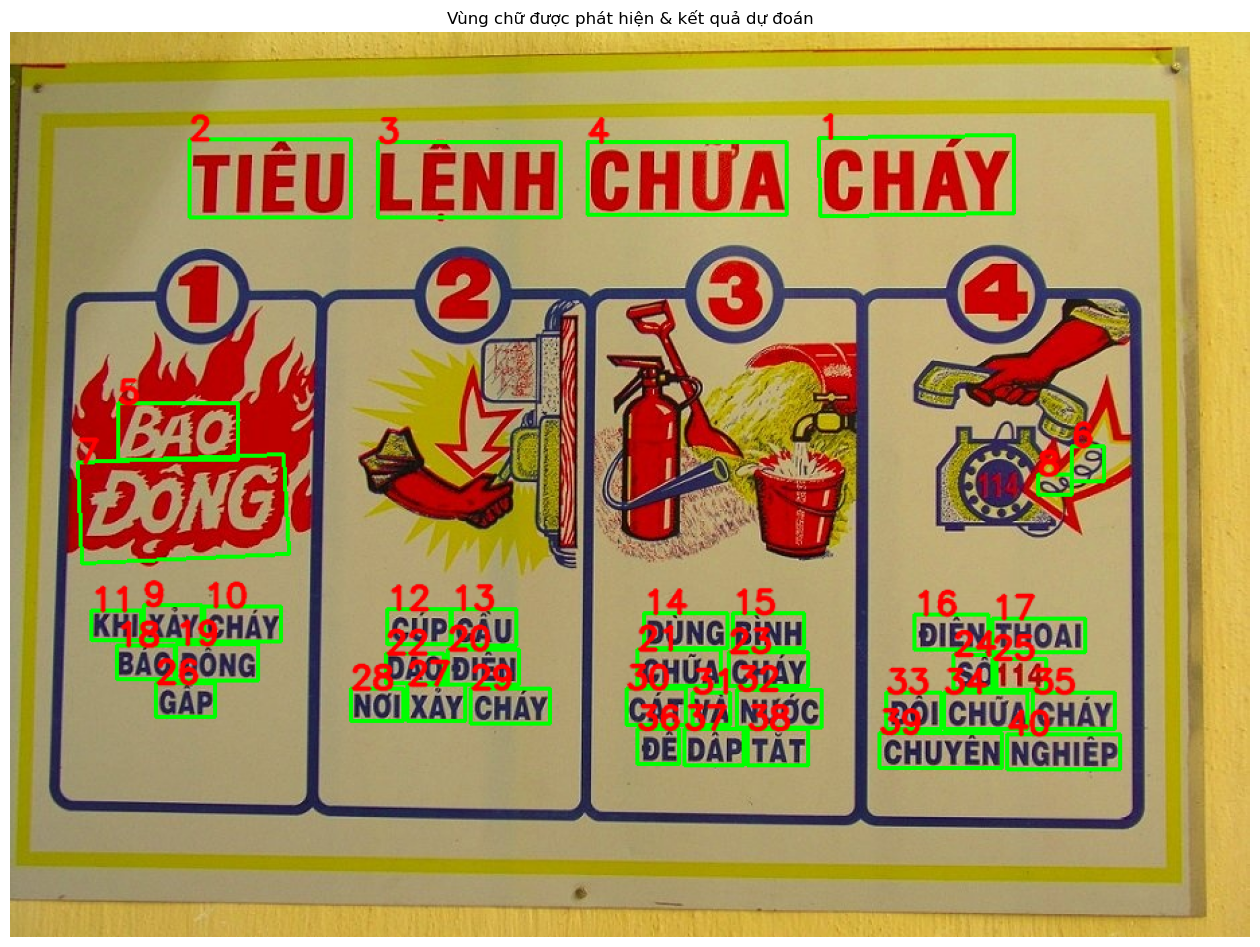


Kết quả dự đoán (10 dòng cuối):
[31]:  <sos>và
[32]:  <sos>nước
[33]:  <sos>đội
[34]:  <sos>cha
[35]:  <sos>cháy
[36]:  <sos>để
[37]:  <sos>dập
[38]:  <sos>tật
[39]:  <sos>chuyên
[40]:  <sos>nghiệp


In [11]:
img_path = os.path.join(VIETNAMESE_DATA_PATH, 'unseen_test_images', 'im1749.jpg')
text_detected = inference(model, img_path, inference_transform, CRAFT_MODEL_PATH, vocab=vocab, device=device, max_len=MAX_LEN, beam_width=5)

print("\nKết quả dự đoán (10 dòng cuối):")
for item in text_detected[-10:]:
    print(f"[{item['index']}]:  {item['text']}")

Phát hiện 21 vùng chữ trong ảnh.


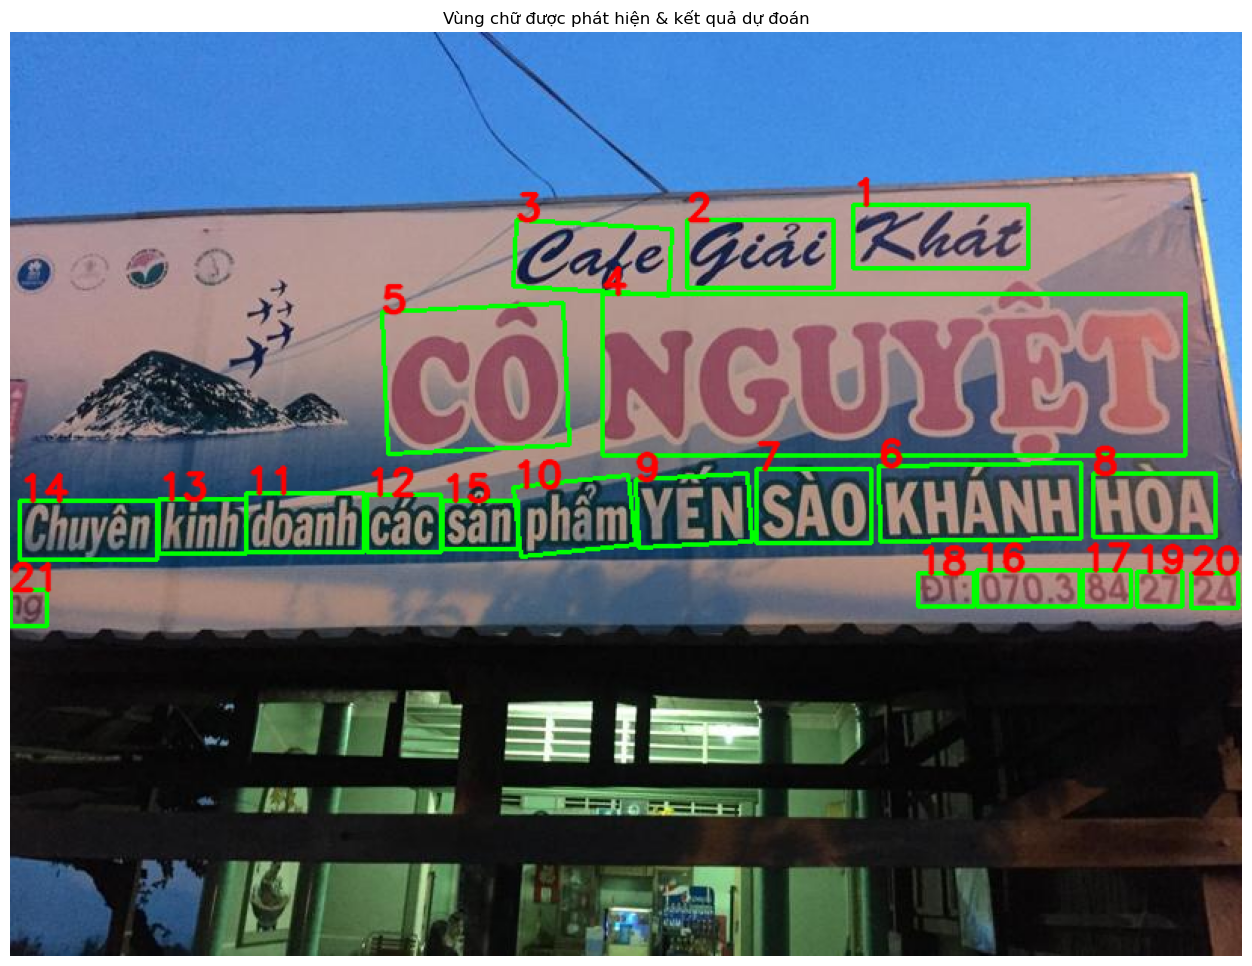


Kết quả dự đoán (10 từ đầu):
[1]:  <sos>khát
[2]:  <sos>giát
[3]:  <sos>cafe
[4]:  <sos>nguyên
[5]:  <sos>cô
[6]:  <sos>khánh
[7]:  <sos>sào
[8]:  <sos>hoà
[9]:  <sos>yến
[10]:  <sos>đhẩm

Kết quả dự đoán (10 từ cuối):
[12]:  <sos>các
[13]:  <sos>kính
[14]:  <sos>chuyên
[15]:  <sos>sản
[16]:  <sos>0702
[17]:  <sos>14
[18]:  <sos>đt
[19]:  <sos>27
[20]:  <sos>2a
[21]:  <sos>yộ


In [12]:
img_path = os.path.join(VIETNAMESE_DATA_PATH, 'train_images', 'im0007.jpg')

text_detected = inference(model, img_path, inference_transform, CRAFT_MODEL_PATH, vocab=vocab, device=device, max_len=MAX_LEN, beam_width=5)

print("\nKết quả dự đoán (10 từ đầu):")
for item in text_detected[:10]:
    print(f"[{item['index']}]:  {item['text']}")

print("\nKết quả dự đoán (10 từ cuối):")
for item in text_detected[-10:]:
    print(f"[{item['index']}]:  {item['text']}")


Phát hiện 8 vùng chữ trong ảnh.


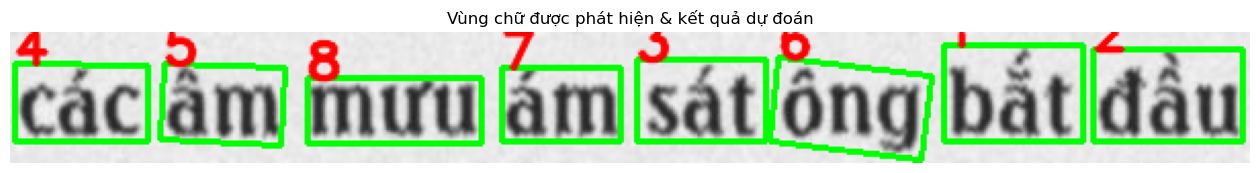


Kết quả dự đoán:
[1]:  <sos>bất
[2]:  <sos>đầu
[3]:  <sos>sát
[4]:  <sos>các
[5]:  <sos>am
[6]:  <sos>cônh
[7]:  <sos>ấm
[8]:  <sos>mửu


In [13]:
img_path = os.path.join(VIETOCR_DATA_PATH, 'images', '4023.jpg')
text_detected = inference(model, img_path, inference_transform, CRAFT_MODEL_PATH, vocab=vocab, device=device, max_len=MAX_LEN, beam_width=5)

print("\nKết quả dự đoán:")
for item in text_detected:
    print(f"[{item['index']}]:  {item['text']}")

Phát hiện 150 vùng chữ trong ảnh.


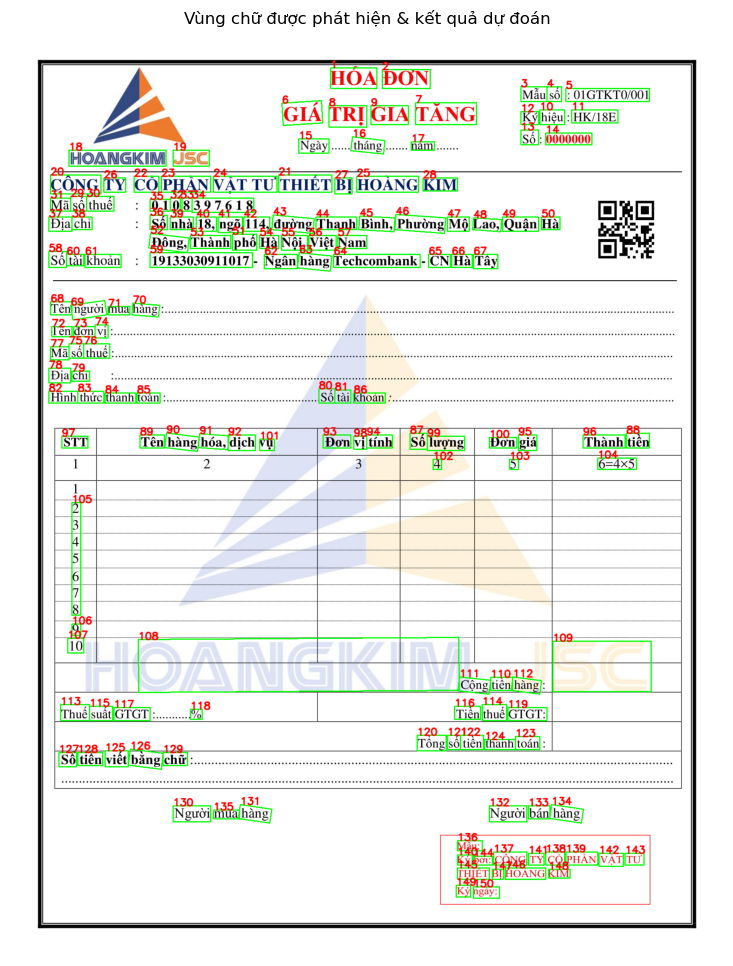


Kết quả dự đoán (10 từ đầu):
[1]:  <sos>hoá
[2]:  <sos>đơn
[3]:  <sos>màu
[4]:  <sos>1số
[5]:  <sos>eciotral
[6]:  <sos>giá
[7]:  <sos>tăng
[8]:  <sos>trị
[9]:  <sos>gia
[10]:  <sos>hiệu

Kết quả dự đoán (20-30):
[21]:  <sos>thiết
[22]:  <sos>co
[23]:  <sos>phân
[24]:  <sos>wate
[25]:  <sos>hoàng
[26]:  <sos>ty
[27]:  <sos>bi
[28]:  <sos>kim
[29]:  <sos>số
[30]:  <sos>ic
[31]:  <sos>mải


In [14]:
img_path = os.path.join(DATA_PATH, 'hoa_don.jpg')
text_detected = inference(model, img_path, inference_transform, CRAFT_MODEL_PATH, vocab=vocab, device=device, max_len=MAX_LEN, beam_width=5)

print("\nKết quả dự đoán (10 từ đầu):")
for item in text_detected[:10]:
    print(f"[{item['index']}]:  {item['text']}")

print("\nKết quả dự đoán (20-30):")
for item in text_detected[20:31]:
    print(f"[{item['index']}]:  {item['text']}")

Phát hiện 1 vùng chữ trong ảnh.


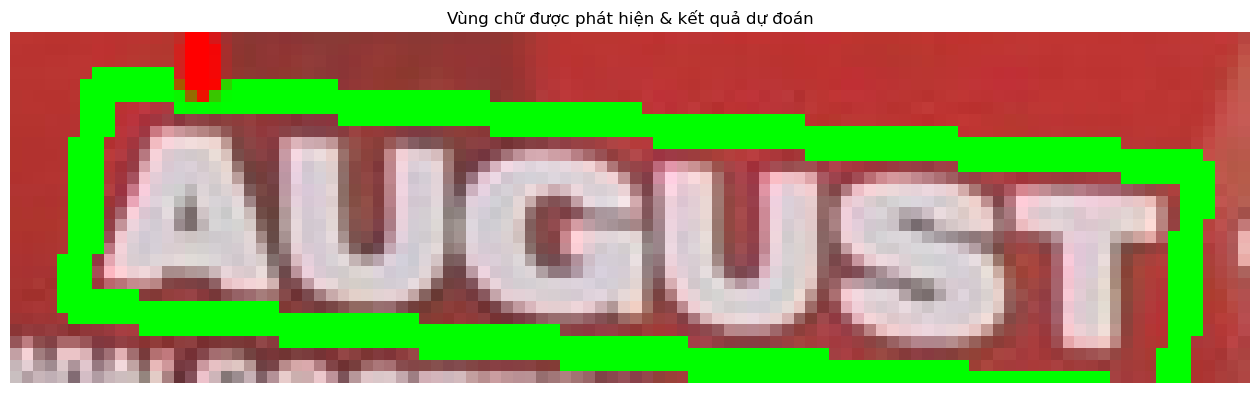


Kết quả dự đoán:
[1]:  <sos>august


In [15]:
img_path = os.path.join(IIIT5K_DATA_PATH, 'test', '73_12.png')
text_detected = inference(model, img_path, inference_transform, CRAFT_MODEL_PATH, vocab=vocab, device=device, max_len=MAX_LEN, beam_width=5)

print("\nKết quả dự đoán:")
for item in text_detected:
    print(f"[{item['index']}]:  {item['text']}")